In [4]:
include("KPNormal.jl")
using Distributions, KP, Interpolations, PyPlot, KernelEstimator

/Users/vishalgupta/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [59]:
### This is very expensive... Dont' run unnecessarily
## Build a simple lamstar approximation with the stuff we have
#Simple Gaussian Set-up
n = 100000
tau0 = 2
vs = 1 * rand(n)
cs = rand(n)  * 2 * 10
thetas = randn(n) /sqrt(tau0) 
zs = thetas + randn(n) ./ sqrt(vs);
xs = zs + randn(n) ./ sqrt(vs)

qt, tau_grid_full, objs  = KP.best_x_tau(cs, zs, vs, thetas)
lam2 = map(t-> KP.lam(zs, t, vs, cs), tau_grid_full )

qtx, tau_grid_fullx, objsx  = KP.best_x_tau(cs, xs, vs, thetas)
lam2x = map(t-> KP.lam(xs, t, vs, cs), tau_grid_fullx )


#smooth it with an interpolator...  only need the values between 0 and 5
filt = tau_grid_full .< 5
println("No. of Pts In interpolator:\t", sum(filt))
tau_grid= collect(0:.01:5)
lamstar = npr(tau_grid_full[filt], lam2[filt], xeval=tau_grid, reg=localconstant);

filt = tau_grid_fullx .< 5
println("No. of Pts In interpolator:\t", sum(filt))
lamstarx = npr(tau_grid_fullx[filt], lam2x[filt], xeval=tau_grid, reg=localconstant);

No. of Pts In interpolator:	13916
No. of Pts In interpolator:	14308


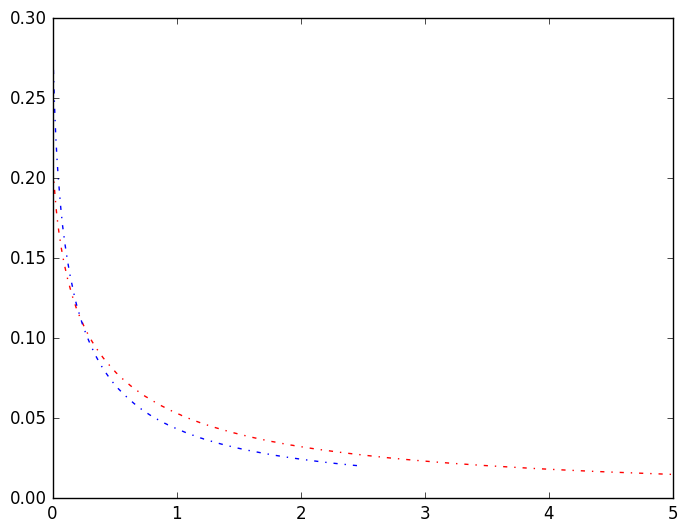

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32a7e7550>

In [65]:
#PyPlot.plot(tau_grid_full[filt], lam2[filt], ".")
PyPlot.plot(tau_grid, lamstar, "-.r")
PyPlot.plot(tau_grid/2, lamstarx, "-.b")

## Understand limiting behavior of objective

In [56]:
#New data
#Simple Gaussian Set-up
n = 100000
tau0 = 2
vs = 1 * rand(n)
cs = rand(n)  * 2 * 10
thetas = randn(n) /sqrt(tau0) 
zs = thetas + randn(n) ./ sqrt(vs);
xs = zs + randn(n) ./ sqrt(vs);

In [57]:
#actual obj value
tau_grid = collect(0.:.01:5.)
shrunk_objs = zeros(length(tau_grid))
theta_objs =  zeros(length(tau_grid))
shrunk_inds = zeros(length(tau_grid))
shrunk_theta = zeros(length(tau_grid))
shrunk_inds_limit = zeros(length(tau_grid))
shrunk_theta_limit = zeros(length(tau_grid))
theta_objs_x = zeros(length(tau_grid))

inds = zeros(Float64, n)

for ix = 1:length(tau_grid)
    shrunk_zs = KP.shrink(zs, vs, tau_grid[ix])
    qs, lam = KP.x_dual(cs, shrunk_zs)
    shrunk_objs[ix] = mean(shrunk_zs .* qs)
    theta_objs[ix] = mean(thetas .* qs)
    
    shrunk_xs = KP.shrink(xs, vs, 2 * tau_grid[ix])
    qs_x = KP.x(cs, shrunk_xs)
    theta_objs_x[ix] = mean(thetas .* qs_x)
    
    
    fill!(inds, 0.)
    inds[ shrunk_zs .> lam .* cs] = 1.    
    shrunk_inds[ix] = mean(shrunk_zs .* inds)
    shrunk_theta[ix] = mean(thetas .* inds)
    
    fill!(inds, 0.)
    inds[ shrunk_zs .> lamstar[ix] .* cs] = 1.    
    shrunk_inds_limit[ix] = mean(shrunk_zs .* inds)
    shrunk_theta_limit[ix] = mean(thetas .* inds)
end


0.06826170884471636 0.0514804826360296


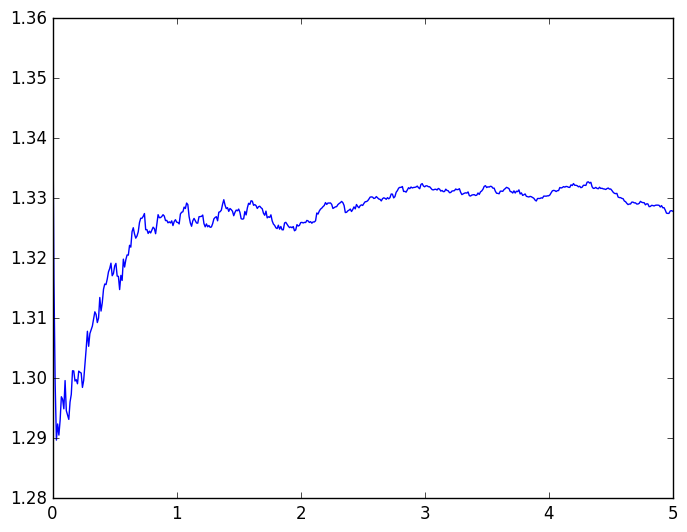

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324637110>

In [58]:
# plot(tau_grid, theta_objs, "--k")
# plot(tau_grid, shrunk_theta_limit, "--r")
# plot(tau_grid, theta_objs_x, "--b")

println( theta_objs[findfirst(tau_grid .>= tau0)], " " , theta_objs_x[findfirst(tau_grid .>= tau0)] )

plot(tau_grid, theta_objs ./ theta_objs_x)
#ylim(0, 10)

# (theta_objs./theta_objs_x)[20:300]

In [54]:
1/1.3, sqrt(2)

(0.7692307692307692,1.4142135623730951)

In [ ]:
function remTerm(tau, zs, tau0, vs, cs)
    qs = KP.x(cs, KP.shrink(zs, vs, tau))
    dot(KP.shrink(zs, vs, tau0)-KP.shrink(zs, vs, tau), qs)/n
end

tau_grid = collect(0.:.01:5.)
out = map(t-> remTerm(t, zs, tau0, vs, cs), tau_grid)
#PyPlot.plot(tau_grid, out, ".-b")

duals = map(t -> KP.dual_obj(zs, t, vs, cs), tau_grid)
#PyPlot.plot(tau_grid, duals, ".-r")

dual_limit = [lamstar[i] + mean(max(KP.shrink(zs, vs, tau_grid[i]) - lamstar[i] * cs, 0)) for i =1:length(tau_grid)];

In [ ]:
println( tau_grid[indmax(duals+out)], tau_grid[indmax(dual_limit+out)])
PyPlot.plot(tau_grid, duals + out, ".-k")
PyPlot.plot(tau_grid, dual_limit + out, ".-r")
PyPlot.xlim(0, 2)


In [ ]:
tau_grid = collect(0.:.1:5.)
slams = map(t -> scaled_lam(zs, t, vs, cs), tau_grid)
plot(x=tau_grid, y=slams, Geom.point, Geom.line)


In [ ]:
tau_grid = collect(0.:.1:5.)
q_grid = map(t -> dot(thetas, KP.x(cs, KP.shrink(zs, vs, t)))/n, tau_grid)
plot(x=tau_grid, y=q_grid, Geom.point, Geom.line)

In [ ]:
out_approx = map(t -> sum(thetas[KP.shrink(zs, vs, t) .>= itp[t]])/n, tau_grid)
plot(x=tau_grid, y=out_approx, Geom.point, Geom.line)

In [ ]:
##Check the indicator claim  x(tau ,Z) = Indicator( alpha Z > lambda * )
#gen some new data
thetas = randn(n) /sqrt(tau0) 
zs = thetas + randn(n) ./ sqrt(vs)

tau = 5
q_primal, dual_val = KP.x_dual(cs, KP.shrink(zs, vs, tau))
x_dual = zeros(n)
x_dual[ KP.shrink(zs, vs, tau) ./ cs .> itp[tau] ] = 1

println(dual_val, "\t", itp[tau])
norm(q_primal-x_dual)/n

## Relation between TauZ grid and TauX grid

In [ ]:
#Simple Gaussian Set-up
n = 100000
tau0 = 1
vs =  1 * rand(n)
cs = rand(n)  * 2 * 10
thetas = randn(n) /sqrt(tau0) 
zs = thetas + randn(n) ./ sqrt(vs);
xs = zs + randn(n) ./ sqrt(vs)
ys = 2*zs - xs;

qz_star, tau_z, qz_grid = KP.best_x_tau(cs, zs, vs, thetas)
qx_star, tau_x, qx_grid = KP.best_x_tau(cs, xs, vs, thetas);

In [ ]:
println("TauOR_Z: \t", tau_z[indmax(qz_grid)])
println("TauOR_X: \t", tau_x[indmax(qx_grid)])
println("TauO: \t \t", tau0)
println()
println("Obj_ORZ: \t", maximum(qz_grid))
println("Obj_ORX: \t", maximum(qx_grid))
println("Obj_Tau0Z: \t", qz_grid[findfirst(t->t >= tau0, tau_z)], "\t", qz_grid[findlast(t->t <= tau0, tau_z)])
println("Obj_Tau0X: \t", qx_grid[findfirst(t->t >= tau0, tau_x)], "\t", qx_grid[findlast(t->t <= tau0, tau_x)])

In [ ]:
#plot them together
figure(figsize=(4, 6))
PyPlot.plot(tau_z, qz_grid, "-.b")
PyPlot.plot(tau_x, qx_grid, "-.r")
PyPlot.xlim(0, 2)
PyPlot.ylim(.08, .125)

In [ ]:
#rescale them to same y axis and plot them together
scale = mean(qz_grid[end-20:end]) / mean(qx_grid[end-20:end])
figure(figsize=(4, 6))
PyPlot.plot(tau_z, qz_grid, "-.b")
PyPlot.plot(tau_x, scale * qx_grid, "-.r")
PyPlot.xlim(0, 5)
PyPlot.ylim(.08, .128)

In [ ]:
#rescale the tau axis and replot them
scale = mean(qz_grid[end-20:end]) / mean(qx_grid[end-20:end])
figure(figsize=(4, 6))
PyPlot.plot(tau_z, qz_grid, "-.b")
PyPlot.plot(tau_x * 2, scale * qx_grid, "-.r")
PyPlot.xlim(0, 5)
PyPlot.ylim(.08, .128)

## Is Lambda(\tau, Z) continuous in \tau?

In [16]:
#What does the objective funciton look like?  Is the solution unique?
n = 5
tau0 = 1
vs =  1 * rand(n)
cs = rand(n)  * 2 * 10
thetas = randn(n) /sqrt(tau0) 
zs = thetas + randn(n) ./ sqrt(vs);

function dual_obj(lam, tau)
    lam + 1/n *sum( max(0, KP.shrink(zs, vs, tau) - lam * cs) )
end

dual_obj (generic function with 1 method)

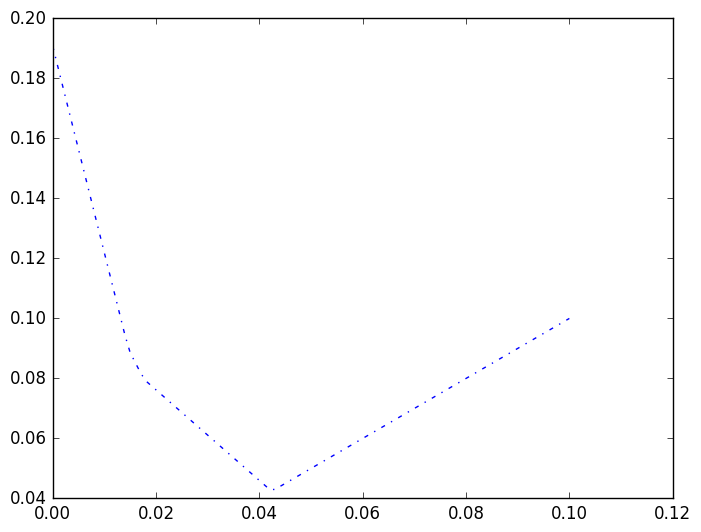

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31f53d850>

In [17]:
lam_grid = collect(0:.001:.1)
out = map(l-> dual_obj(l, 1), lam_grid)

plot(lam_grid, out, "-.b")